# Spatial Regression

Demonstrating a couple non-spatial regression models:

    1) Linear Regression
    2) Poisson Regression

Demonstrating various spatial regression models:

    1) Spatial Error Model
    2) Spatial Lag Model
    3) Combined Spatial Error and Lag Model
    4) Spatial Regimes Model (OLS, Spatial Error, Spatial Lag, Combined Spatial Error and Lag)
    5) Geographically Weighted Regression (locally varying parameters)

In [1]:
import pandas as pd
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import libpysal
import seaborn as sns
import contextily as cx
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
import numpy as np
figsize(8,6)
%load_ext rpy2.ipython

# Gather the Data

## NYC Taxi Zones

Source: https://data.cityofnewyork.us/Transportation/NYC-Taxi-Zones/d3c5-ddgc

In [2]:
gpd.__version__

'0.9.0'

In [3]:
url = "https://data.cityofnewyork.us/api/geospatial/d3c5-ddgc?method=export&format=GeoJSON"
taxi_zones = gpd.read_file(url)
taxi_zones = taxi_zones.to_crs(4326)
taxi_zones['location_id'] = taxi_zones['location_id'].astype(int)
taxi_zones = taxi_zones.dissolve('location_id').reset_index()
taxi_zones = taxi_zones[taxi_zones['zone'] != 'Newark Airport']
taxi_zones['is_airport'] = taxi_zones['zone'].apply(lambda x: 1 if 'Airport' in x else 0)

In [4]:
taxi_zones.head()

,location_id,geometry,shape_area,objectid,shape_leng,zone,borough,is_airport
1,2,"MULTIPOLYGON (((-73.86969 40.58231, -73.87000 ...",0.00486634037837,2,0.43346966679,Jamaica Bay,Queens,0
2,3,"POLYGON ((-73.84793 40.87134, -73.84725 40.870...",0.000314414156821,3,0.0843411059012,Allerton/Pelham Gardens,Bronx,0
3,4,"POLYGON ((-73.97177 40.72582, -73.97179 40.725...",0.000111871946192,4,0.0435665270921,Alphabet City,Manhattan,0
4,5,"POLYGON ((-74.17422 40.56257, -74.17349 40.562...",0.000497957489363,5,0.0921464898574,Arden Heights,Staten Island,0
5,6,"POLYGON ((-74.06367 40.60220, -74.06351 40.602...",0.000606460984581,6,0.150490542523,Arrochar/Fort Wadsworth,Staten Island,0


/Users/willgeary/miniconda3/envs/geo/lib/python3.10/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


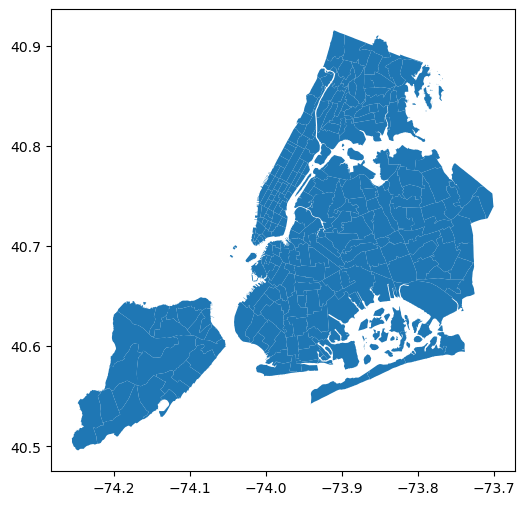

In [5]:
taxi_zones.plot();

## Ridehail Trip Data

Source: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

In [6]:
url = "https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2023-01.parquet"

In [7]:
%%time
trips = pd.read_parquet(url)

CPU times: user 7.17 s, sys: 3.67 s, total: 10.8 s
Wall time: 10.6 s


## Pickups per Taxi Zone

In [8]:
pickups_per_zone = trips['PULocationID'].value_counts()
avg_daily_pickups_per_zone = pickups_per_zone / 30
avg_daily_pickups_per_zone = pd.DataFrame(avg_daily_pickups_per_zone)
avg_daily_pickups_per_zone = avg_daily_pickups_per_zone.reset_index()
avg_daily_pickups_per_zone.columns = ['location_id','pickups']

In [9]:
avg_daily_pickups_per_zone.head()

,location_id,pickups
0,132,11537.933333
1,138,10253.000000
2,79,9201.966667
3,230,8068.333333
4,61,8035.000000


In [10]:
taxi_zones = pd.merge(taxi_zones, avg_daily_pickups_per_zone, how='left', on='location_id')

In [11]:
taxi_zones['area_sq_mile'] = taxi_zones['geometry'].to_crs(6933).area / 2.59e+6

In [12]:
taxi_zones['pickups_per_sq_mile'] = taxi_zones['pickups'] / taxi_zones['area_sq_mile']

In [13]:
taxi_zones = taxi_zones.dropna()

In [14]:
taxi_zones = taxi_zones.reset_index()

/Users/willgeary/miniconda3/envs/geo/lib/python3.10/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


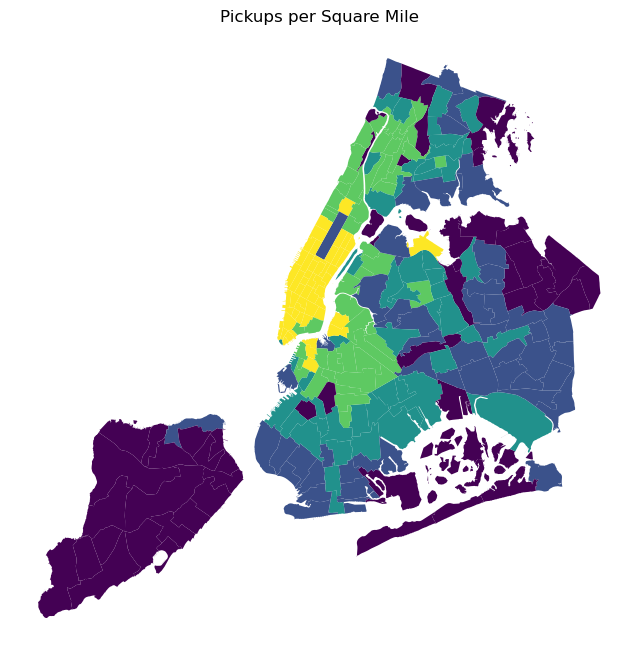

In [15]:
fig, ax = plt.subplots(figsize=(8,8))
taxi_zones.plot(column='pickups_per_sq_mile', ax=ax, scheme='quantiles')
plt.title("Pickups per Square Mile")
ax.axis('off');

## Population per Taxi Zone

Source: LandScan Daytime and Nighttime Population

In [16]:
from rasterstats import zonal_stats
import warnings
warnings.filterwarnings("ignore")

In [17]:
night_pop_path = "../../data/LandScan/LandScanConusNight.tif"

In [18]:
taxi_zones_night_pops = zonal_stats(taxi_zones, night_pop_path, stats='sum')

In [19]:
day_pop_path = "../../data/LandScan/LandScanConusDay.tif"

In [20]:
taxi_zones_day_pops = zonal_stats(taxi_zones, day_pop_path, stats='sum')

In [21]:
taxi_zones['night_pop'] = [i['sum'] for i in taxi_zones_night_pops]
taxi_zones['day_pop'] = [i['sum'] for i in taxi_zones_day_pops]

In [22]:
taxi_zones['night_pop_per_sq_mile'] = taxi_zones['night_pop'] / taxi_zones['area_sq_mile'] 
taxi_zones['day_pop_per_sq_mile'] = taxi_zones['day_pop'] / taxi_zones['area_sq_mile'] 

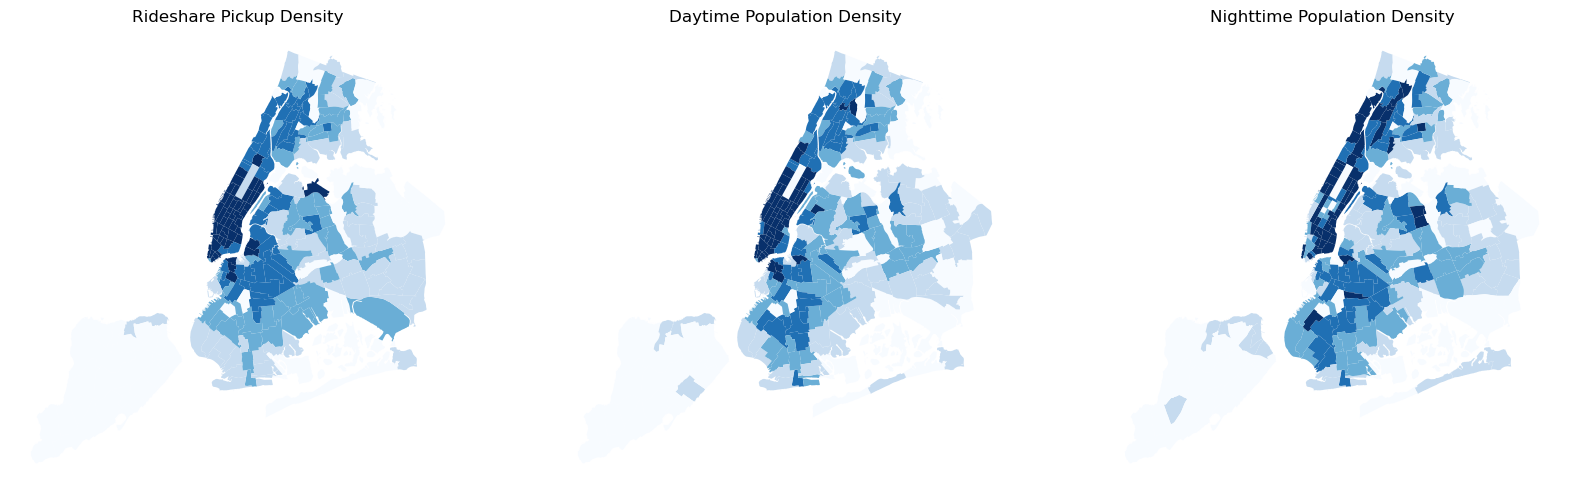

In [23]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(20,20))
taxi_zones.plot(column='pickups_per_sq_mile', ax=ax1, scheme='quantiles', cmap='Blues')
taxi_zones.plot(column='day_pop_per_sq_mile', ax=ax2, scheme='quantiles', cmap='Blues')
taxi_zones.plot(column='night_pop_per_sq_mile', ax=ax3, scheme='quantiles', cmap='Blues')
ax1.set_title("Rideshare Pickup Density")
ax2.set_title("Daytime Population Density")
ax3.set_title("Nighttime Population Density")
for ax in [ax1, ax2, ax3]:
    ax.axis('off');

# Regression Modeling

## Linear Regression

In [24]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [25]:
formula = "pickups_per_sq_mile ~ night_pop_per_sq_mile + day_pop_per_sq_mile + C(is_airport)"

In [26]:
linear_regression = smf.ols(formula, data=taxi_zones).fit()

In [27]:
linear_regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     pickups_per_sq_mile   R-squared:                       0.802
Model:                             OLS   Adj. R-squared:                  0.800
Method:                  Least Squares   F-statistic:                     342.7
Date:                 Wed, 12 Apr 2023   Prob (F-statistic):           5.87e-89
Time:                         10:28:16   Log-Likelihood:                -2465.4
No. Observations:                  258   AIC:                             4939.
Df Residuals:                      254   BIC:                             4953.
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              -910.5304    358.265     -2.541      0.012   -1616.080    -204.981
C(is_airport)[T.1]     5902.7996   2462.020      2.398      0.017    1054.226    1.08e+04
night_pop_per_sq_mile     0.0647      0.007      9.929      0.000       0.052       0.078
day_pop_per_sq_mile       0.0418      0.001     27.948      0.000       0.039       0.045
==============================================================================
Omnibus:                      125.261   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              871.613
Skew:                           1.813   Prob(JB):                    5.39e-190
Kurtosis:                      11.242   Cond. No.                     1.94e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.94e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [28]:
taxi_zones['linear_regression_prediction_error'] = linear_regression.fittedvalues - taxi_zones['pickups_per_sq_mile']

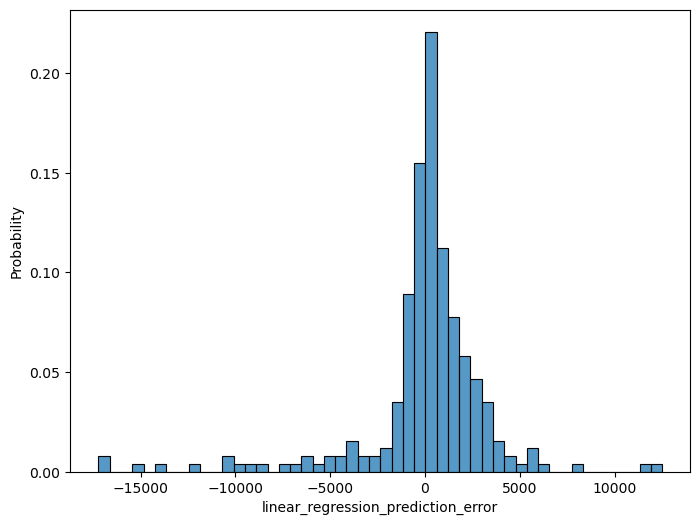

In [29]:
sns.histplot(taxi_zones['linear_regression_prediction_error'], stat='probability');

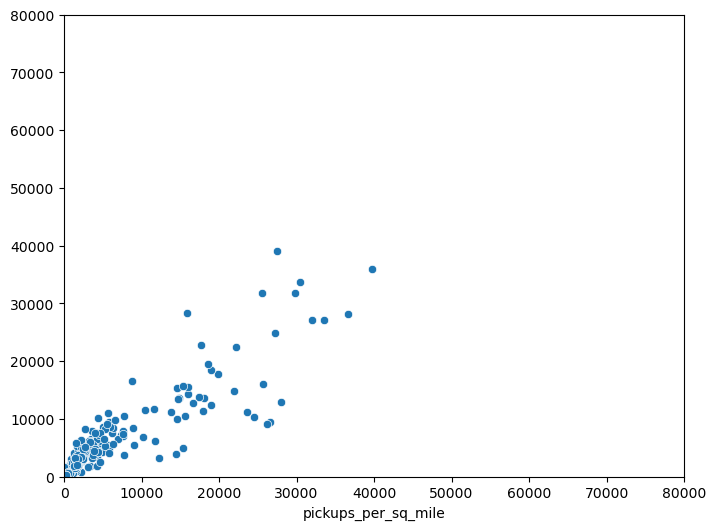

In [30]:
sns.scatterplot(x=taxi_zones['pickups_per_sq_mile'], y=linear_regression.fittedvalues)
plt.ylim(0,80000)
plt.xlim(0,80000);

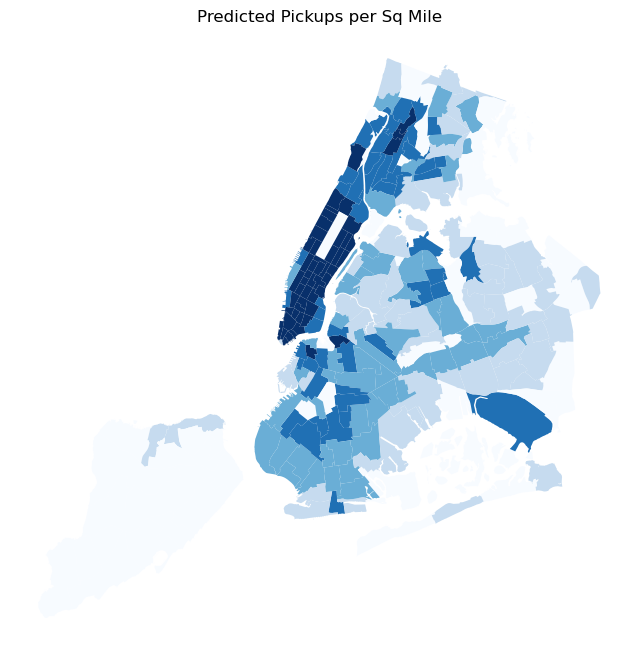

In [31]:
fig, ax = plt.subplots(figsize=(8,8))
taxi_zones.plot(ax=ax, column=linear_regression.fittedvalues, scheme='quantiles', cmap='Blues')
plt.title('Predicted Pickups per Sq Mile')
ax.axis('off');

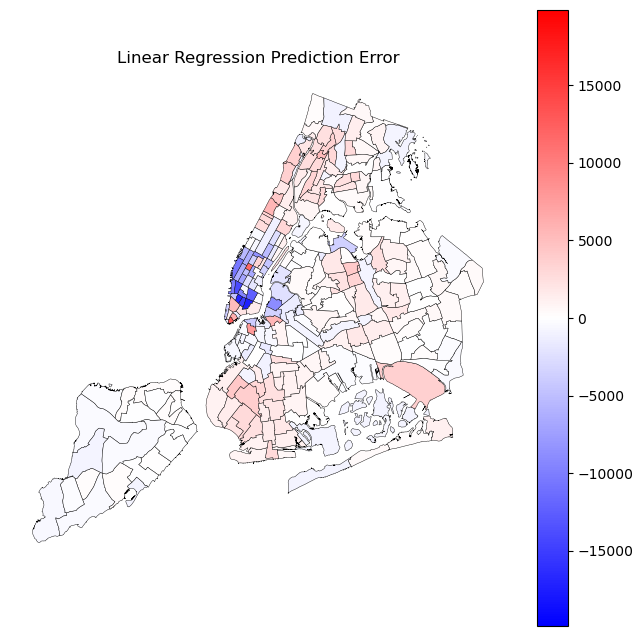

In [32]:
# Create diverging color scheme centered on zero
from matplotlib.colors import TwoSlopeNorm
vmin, vmax, vcenter = (taxi_zones.pickups_per_sq_mile.max()*-1)/2, (taxi_zones.pickups_per_sq_mile.max())/2, 0
norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cmap = 'bwr'
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots(figsize=(8,8))
taxi_zones.plot(ax=ax,column='linear_regression_prediction_error', edgecolor='black', linewidth=0.3, cmap=cmap, norm=norm)
fig.colorbar(cbar, ax=ax)
plt.title('Linear Regression Prediction Error')
ax.axis('off');

## Poisson Regression

Poisson Regression models are best used for modeling events where the outcomes are counts. Or, more specifically, count data: discrete data with non-negative integer values that count something, like the number of times an event occurs during a given timeframe or the number of people in line at the grocery store.

Source: https://www.dataquest.io/blog/tutorial-poisson-regression-in-r

In [33]:
formula = "pickups_per_sq_mile ~ night_pop_per_sq_mile + day_pop_per_sq_mile + C(is_airport)"

In [34]:
poisson_model = smf.glm(formula=formula, data=taxi_zones, family=sm.families.Poisson()).fit()

In [35]:
print(poisson_model.summary())

                  Generalized Linear Model Regression Results                  
Dep. Variable:     pickups_per_sq_mile   No. Observations:                  258
Model:                             GLM   Df Residuals:                      254
Model Family:                  Poisson   Df Model:                            3
Link Function:                     Log   Scale:                          1.0000
Method:                           IRLS   Log-Likelihood:            -2.8835e+05
Date:                 Wed, 12 Apr 2023   Deviance:                   5.7431e+05
Time:                         10:28:16   Pearson chi2:                 7.25e+05
No. Iterations:                      6   Pseudo R-squ. (CS):              1.000
Covariance Type:             nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept           

In [36]:
taxi_zones['poisson_prediction_error'] = poisson_model.fittedvalues - taxi_zones['pickups_per_sq_mile']

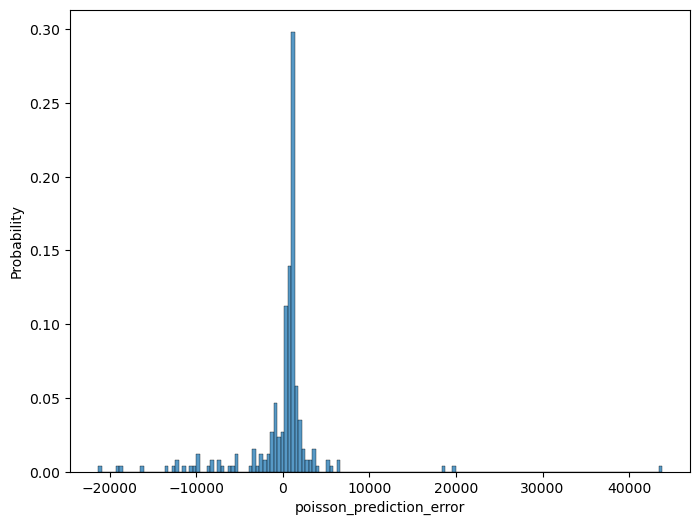

In [37]:
sns.histplot(taxi_zones['poisson_prediction_error'], stat='probability');

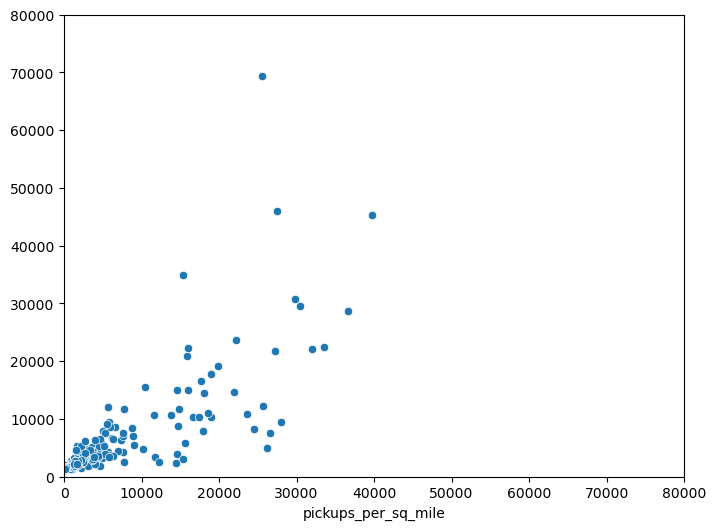

In [38]:
sns.scatterplot(x=taxi_zones['pickups_per_sq_mile'], y=poisson_model.fittedvalues)
plt.ylim(0,80000)
plt.xlim(0,80000);

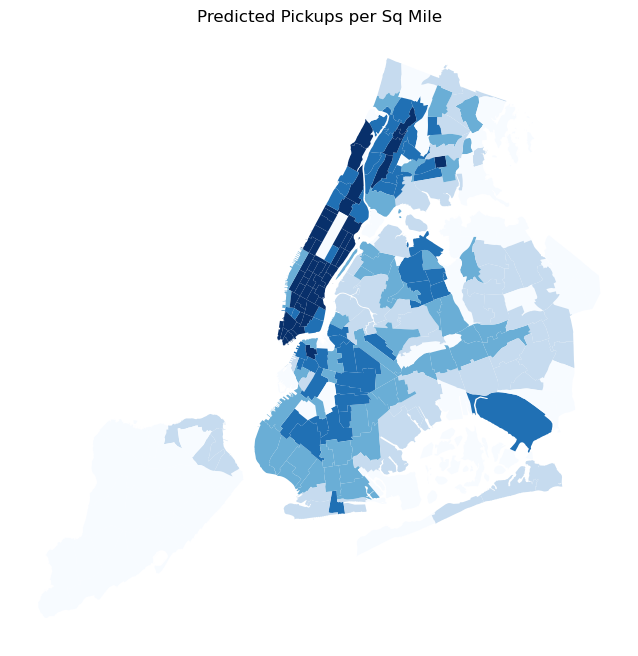

In [39]:
fig, ax = plt.subplots(figsize=(8,8))
taxi_zones.plot(ax=ax, column=poisson_model.fittedvalues, scheme='quantiles', cmap='Blues')
plt.title('Predicted Pickups per Sq Mile')
ax.axis('off');

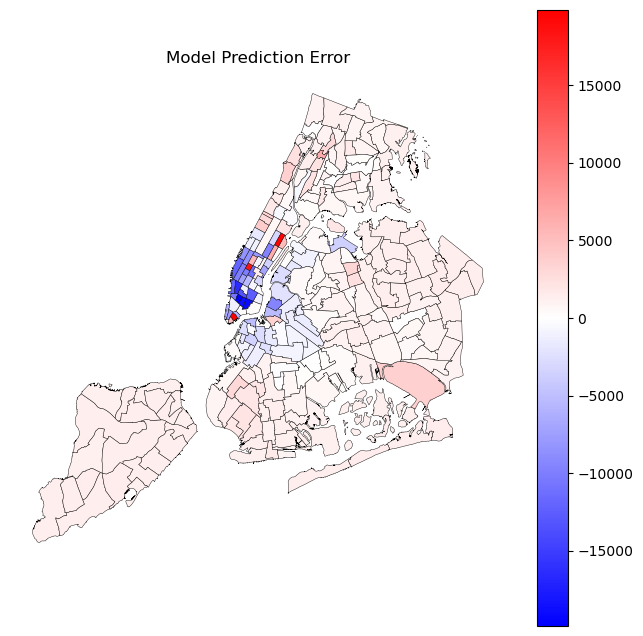

In [40]:
# Create diverging color scheme centered on zero
from matplotlib.colors import TwoSlopeNorm
vmin, vmax, vcenter = (taxi_zones.pickups_per_sq_mile.max()*-1)/2, (taxi_zones.pickups_per_sq_mile.max())/2, 0
norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cmap = 'bwr'
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots(figsize=(8,8))
taxi_zones.plot(ax=ax,column='poisson_prediction_error', edgecolor='black', linewidth=0.3, cmap=cmap, norm=norm)
fig.colorbar(cbar, ax=ax)
plt.title('Model Prediction Error')
ax.axis('off');

## Linear Regression Spatial Diagnostics

Re-run OLS linear regression, this time using PySAL with spatial diagnostics enabled.

First, need to create spatial weigths

In [41]:
# create spatial weights
w = libpysal.weights.KNN.from_dataframe(taxi_zones,k=8)

# Row standardise weights
w.transform = 'R'

Fit an OLS Model with Spatial Diagnostics Enabled

In [42]:
import spreg

In [43]:
target_variable = ['pickups_per_sq_mile']
feature_variables = ['night_pop_per_sq_mile', 'day_pop_per_sq_mile', 'is_airport']

linear_regression_with_spatial_diagnostics = spreg.OLS(
    
    # Target variable
    taxi_zones[target_variable].values, 
    
    # Feature variables
    taxi_zones[feature_variables].values,
    
    # Target variable name
    name_y = target_variable[0], 
    
    # Feature variable names
    name_x = feature_variables,
    
    # Specify the weights
    w = w,
    
    # Enable spatial diagnostics
    spat_diag=True
)

In [44]:
print(linear_regression_with_spatial_diagnostics.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :pickups_per_sq_mile                Number of Observations:         258
Mean dependent var  :   5255.8565                Number of Variables   :           4
S.D. dependent var  :   7694.8160                Degrees of Freedom    :         254
R-squared           :      0.8019
Adjusted R-squared  :      0.7995
Sum squared residual:3014841056.185                F-statistic           :    342.6774
Sigma-square        :11869452.977                Prob(F-statistic)     :   5.873e-89
S.E. of regression  :    3445.207                Log likelihood        :   -2465.413
Sigma-square ML     :11685430.450                Akaike info criterion :    4938.826
S.E of regression ML:   3418.3959                Schwarz criterion     :    4953.038

--------------------------------------------------------------------

    - OLS Regression -> LM Diagnostics
    - Is LM-Error Significant? Yes, pvalue = 0.0
    - Is LM-Lag Significant? Yes, pvalue = 0.0

    Both the LM-Error and LM-Lag tests are significant.

    - Is Robust LM-Error Significant? Yes, pvalue = 0.0
    - Is Robust LM-Lag Significant? Yes, pvalue = 0.0

    Both the Robust LM-Error and LM-Lag are significant. So, use a Combined Spatial Error + Lag Model.

## Spatial Error Model

In [45]:
target_variable = ['pickups_per_sq_mile']
feature_variables = ['night_pop_per_sq_mile', 'day_pop_per_sq_mile', 'is_airport']

spatial_error_model = spreg.ML_Error(
    
    # Target variable
    taxi_zones[target_variable].values, 
    
    # Feature variables
    taxi_zones[feature_variables].values,
    
    # Target variable name
    name_y = target_variable[0], 
    
    # Feature variable names
    name_x = feature_variables,
    
    # Specify the weights
    w = w
)

In [46]:
print(spatial_error_model.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR (METHOD = FULL)
-------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :pickups_per_sq_mile                Number of Observations:         258
Mean dependent var  :   5255.8565                Number of Variables   :           4
S.D. dependent var  :   7694.8160                Degrees of Freedom    :         254
Pseudo R-squared    :      0.8003
Sigma-square ML     : 5684280.390                Log likelihood        :   -2388.764
S.E of regression   :    2384.173                Akaike info criterion :    4785.527
                                                 Schwarz criterion     :    4799.739

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
----------------------------------------------------

In [47]:
taxi_zones['spatial_error_model_prediction_error'] = spatial_error_model.predy[:,0] - taxi_zones['pickups_per_sq_mile']

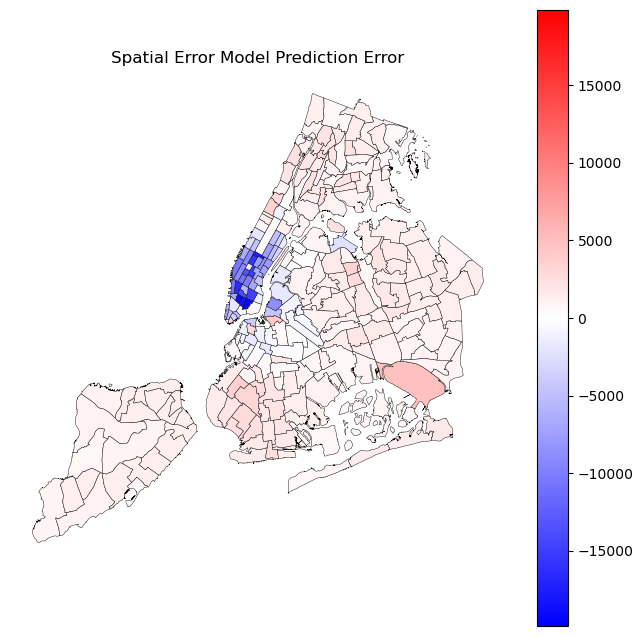

In [48]:
# Create diverging color scheme centered on zero
from matplotlib.colors import TwoSlopeNorm
vmin, vmax, vcenter = (taxi_zones.pickups_per_sq_mile.max()*-1)/2, (taxi_zones.pickups_per_sq_mile.max())/2, 0
norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cmap = 'bwr'
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots(figsize=(8,8))
taxi_zones.plot(ax=ax,column='spatial_error_model_prediction_error', edgecolor='black', linewidth=0.3, cmap=cmap, norm=norm)
fig.colorbar(cbar, ax=ax)
plt.title('Spatial Error Model Prediction Error')
ax.axis('off');

## Spatial Lag Model

In [49]:
target_variable = ['pickups_per_sq_mile']
feature_variables = ['night_pop_per_sq_mile', 'day_pop_per_sq_mile', 'is_airport']

spatial_lag_model = spreg.ML_Lag(
    
    # Target variable
    taxi_zones[target_variable].values, 
    
    # Feature variables
    taxi_zones[feature_variables].values,
    
    # Target variable name
    name_y = target_variable[0], 
    
    # Feature variable names
    name_x = feature_variables,
    
    # Specify the weights
    w = w
)

In [50]:
print(spatial_lag_model.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :pickups_per_sq_mile                Number of Observations:         258
Mean dependent var  :   5255.8565                Number of Variables   :           5
S.D. dependent var  :   7694.8160                Degrees of Freedom    :         253
Pseudo R-squared    :      0.8959
Spatial Pseudo R-squared:  0.8653
Sigma-square ML     : 6141243.941                Log likelihood        :   -2386.526
S.E of regression   :    2478.153                Akaike info criterion :    4783.052
                                                 Schwarz criterion     :    4800.817

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
----------------------

In [51]:
taxi_zones['spatial_lag_model_prediction_error'] = spatial_lag_model.predy[:,0] - taxi_zones['pickups_per_sq_mile']

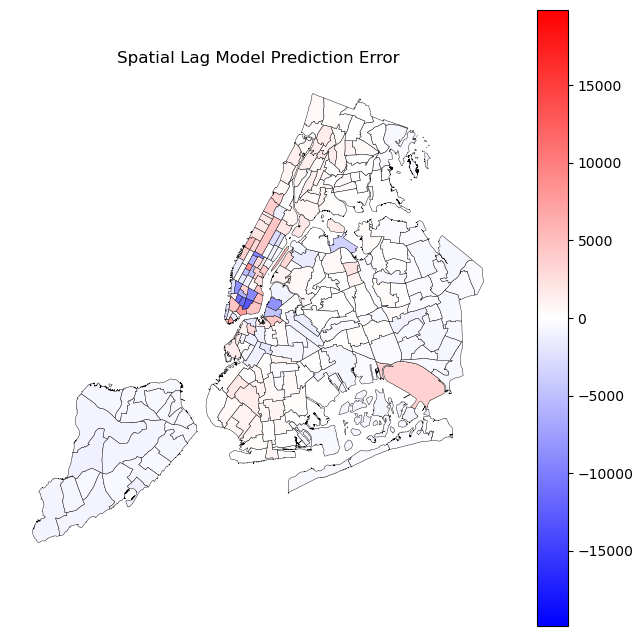

In [52]:
# Create diverging color scheme centered on zero
from matplotlib.colors import TwoSlopeNorm
vmin, vmax, vcenter = (taxi_zones.pickups_per_sq_mile.max()*-1)/2, (taxi_zones.pickups_per_sq_mile.max())/2, 0
norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cmap = 'bwr'
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots(figsize=(8,8))
taxi_zones.plot(ax=ax,column='spatial_lag_model_prediction_error', edgecolor='black', linewidth=0.3, cmap=cmap, norm=norm)
fig.colorbar(cbar, ax=ax)
plt.title('Spatial Lag Model Prediction Error')
ax.axis('off');

## Combined Spatial Error + Lag Model

In [53]:
target_variable = ['pickups_per_sq_mile']
feature_variables = ['night_pop_per_sq_mile', 'day_pop_per_sq_mile', 'is_airport']

spatial_combo_model = spreg.GM_Combo(
    
    # Target variable
    taxi_zones[target_variable].values, 
    
    # Feature variables
    taxi_zones[feature_variables].values,
    
    # Target variable name
    name_y = target_variable[0], 
    
    # Feature variable names
    name_x = feature_variables,
    
    # Specify the weights
    w = w
)

In [54]:
print(spatial_combo_model.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED TWO STAGE LEAST SQUARES
-------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :pickups_per_sq_mile                Number of Observations:         258
Mean dependent var  :   5255.8565                Number of Variables   :           5
S.D. dependent var  :   7694.8160                Degrees of Freedom    :         253
Pseudo R-squared    :      0.8931
Spatial Pseudo R-squared:  0.8615

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT    -1153.4881934     390.6753105      -2.9525495       0.0031516
night_pop_per_sq_mile       0.0430190       0.0055927       7.6919894       0.0000000
 day_pop_per_sq_mile       0

In [55]:
taxi_zones['spatial_combo_model_prediction_error'] = spatial_combo_model.predy[:,0] - taxi_zones['pickups_per_sq_mile']

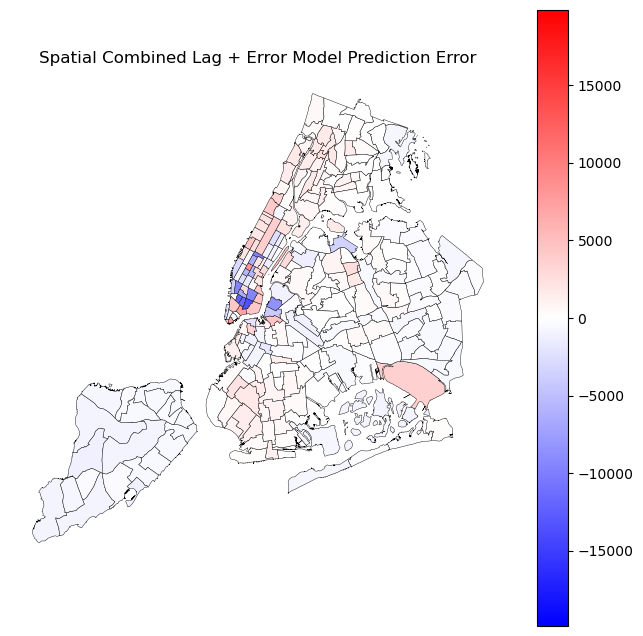

In [56]:
# Create diverging color scheme centered on zero
from matplotlib.colors import TwoSlopeNorm
vmin, vmax, vcenter = (taxi_zones.pickups_per_sq_mile.max()*-1)/2, (taxi_zones.pickups_per_sq_mile.max())/2, 0
norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cmap = 'bwr'
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots(figsize=(8,8))
taxi_zones.plot(ax=ax,column='spatial_combo_model_prediction_error', edgecolor='black', linewidth=0.3, cmap=cmap, norm=norm)
fig.colorbar(cbar, ax=ax)
plt.title('Spatial Combined Lag + Error Model Prediction Error')
ax.axis('off');

## OLS Regimes Model

Using the NYC Boroughs to define regimes.

In [57]:
# If a taxi zone is airport, set its borough to 'Airport'
taxi_zones['regime'] = taxi_zones.apply(lambda row: 'Airport' if row['is_airport']==1 else row['borough'], axis=1)

In [58]:
target_variable = ['pickups_per_sq_mile']
feature_variables = ['night_pop_per_sq_mile', 'day_pop_per_sq_mile']
regimes = taxi_zones['borough']

linear_regression_regimes_model = spreg.OLS_Regimes(
    
    # Target variable
    y = taxi_zones[target_variable].values, 
    
    # Feature variables
    x = taxi_zones[feature_variables].values,
    
    # Specify regimes
    regimes = regimes,
    
    # Target variable name
    name_y = target_variable[0], 
    
    # Feature variable names
    name_x = feature_variables,
    
    # Specify the weights
    w = w,
    
    # Enable spatial diagnostics
    spat_diag=True
)

In [59]:
print(linear_regression_regimes_model.summary)

REGRESSION
----------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES ESTIMATION - REGIME Bronx
-------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :Bronx_pickups_per_sq_mile                Number of Observations:          43
Mean dependent var  :   2377.1246                Number of Variables   :           3
S.D. dependent var  :   1563.3021                Degrees of Freedom    :          40
R-squared           :      0.9336
Adjusted R-squared  :      0.9303
Sum squared residual: 6813482.258                F-statistic           :    281.2978
Sigma-square        :  170337.056                Prob(F-statistic)     :   2.759e-24
S.E. of regression  :     412.719                Log likelihood        :    -318.438
Sigma-square ML     :  158453.076                Akaike info criterion :     642.877
S.E of regression ML:    398.0616                Schwarz criterion     :     648.161

-----------

In [60]:
taxi_zones['linear_regression_regimes_prediction_error'] = linear_regression_regimes_model.predy[:,0] - taxi_zones['pickups_per_sq_mile']

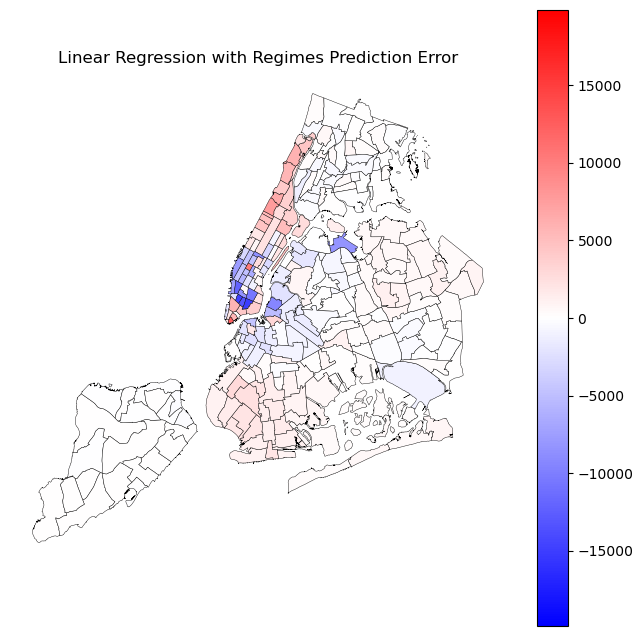

In [61]:
# Create diverging color scheme centered on zero
from matplotlib.colors import TwoSlopeNorm
vmin, vmax, vcenter = (taxi_zones.pickups_per_sq_mile.max()*-1)/2, (taxi_zones.pickups_per_sq_mile.max())/2, 0
norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cmap = 'bwr'
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots(figsize=(8,8))
taxi_zones.plot(ax=ax,column='linear_regression_regimes_prediction_error', edgecolor='black', linewidth=0.3, cmap=cmap, norm=norm)
fig.colorbar(cbar, ax=ax)
plt.title('Linear Regression with Regimes Prediction Error')
ax.axis('off');

## Spatial Error Regimes Model

In [62]:
target_variable = ['pickups_per_sq_mile']
feature_variables = ['night_pop_per_sq_mile', 'day_pop_per_sq_mile']
regimes = taxi_zones['borough']

spatial_error_regimes_model = spreg.ML_Error_Regimes(
    
    # Target variable
    y = taxi_zones[target_variable].values, 
    
    # Feature variables
    x = taxi_zones[feature_variables].values,
    
    # Specify regimes
    regimes = regimes,
    
    # Target variable name
    name_y = target_variable[0], 
    
    # Feature variable names
    name_x = feature_variables,
    
    # Specify the weights
    w = w
)

In [63]:
print(spatial_error_regimes_model.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR - REGIMES (METHOD = full)
-----------------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :pickups_per_sq_mile                Number of Observations:         258
Mean dependent var  :   5255.8565                Number of Variables   :          15
S.D. dependent var  :   7694.8160                Degrees of Freedom    :         243
Pseudo R-squared    :      0.8257
Sigma-square ML     : 6314613.980                Log likelihood        :   -2386.082
S.E of regression   :    2512.890                Akaike info criterion :    4802.164
                                                 Schwarz criterion     :    4855.459

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
--------------------------------

In [64]:
taxi_zones['spatial_error_regimes_prediction_error'] = spatial_error_regimes_model.predy[:,0] - taxi_zones['pickups_per_sq_mile']

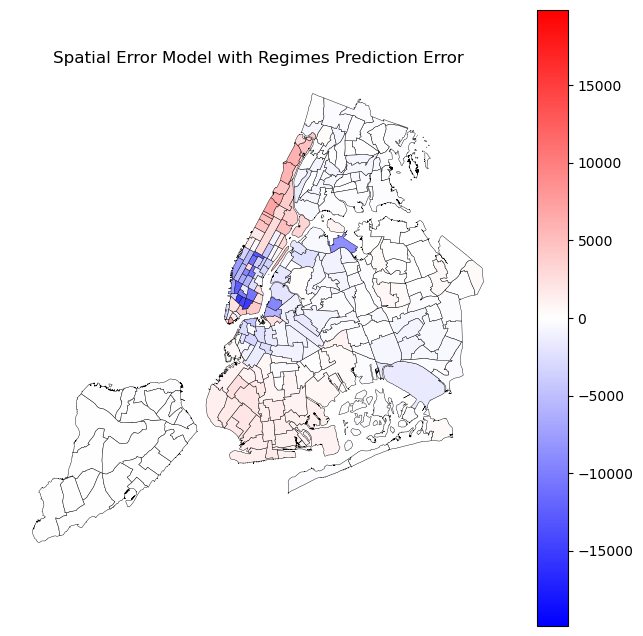

In [65]:
# Create diverging color scheme centered on zero
from matplotlib.colors import TwoSlopeNorm
vmin, vmax, vcenter = (taxi_zones.pickups_per_sq_mile.max()*-1)/2, (taxi_zones.pickups_per_sq_mile.max())/2, 0
norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cmap = 'bwr'
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots(figsize=(8,8))
taxi_zones.plot(ax=ax,column='spatial_error_regimes_prediction_error', edgecolor='black', linewidth=0.3, cmap=cmap, norm=norm)
fig.colorbar(cbar, ax=ax)
plt.title('Spatial Error Model with Regimes Prediction Error')
ax.axis('off');

## Spatial Lag Regimes Model

In [66]:
target_variable = ['pickups_per_sq_mile']
feature_variables = ['night_pop_per_sq_mile', 'day_pop_per_sq_mile']
regimes = taxi_zones['borough']

spatial_lag_regimes_model = spreg.ML_Lag_Regimes(
    
    # Target variable
    y = taxi_zones[target_variable].values, 
    
    # Feature variables
    x = taxi_zones[feature_variables].values,
    
    # Specify regimes
    regimes = regimes,
    
    # Target variable name
    name_y = target_variable[0], 
    
    # Feature variable names
    name_x = feature_variables,
    
    # Specify the weights
    w = w
)

In [67]:
print(spatial_lag_regimes_model.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG - REGIMES (METHOD = full)
---------------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :pickups_per_sq_mile                Number of Observations:         258
Mean dependent var  :   5255.8565                Number of Variables   :          16
S.D. dependent var  :   7694.8160                Degrees of Freedom    :         242
Pseudo R-squared    :      0.8978
Spatial Pseudo R-squared:  0.8699
Sigma-square ML     : 6026872.358                Log likelihood        :   -2384.587
S.E of regression   :    2454.969                Akaike info criterion :    4801.173
                                                 Schwarz criterion     :    4858.021

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
--

In [68]:
taxi_zones['spatial_lag_regimes_prediction_error'] = spatial_lag_regimes_model.predy[:,0] - taxi_zones['pickups_per_sq_mile']

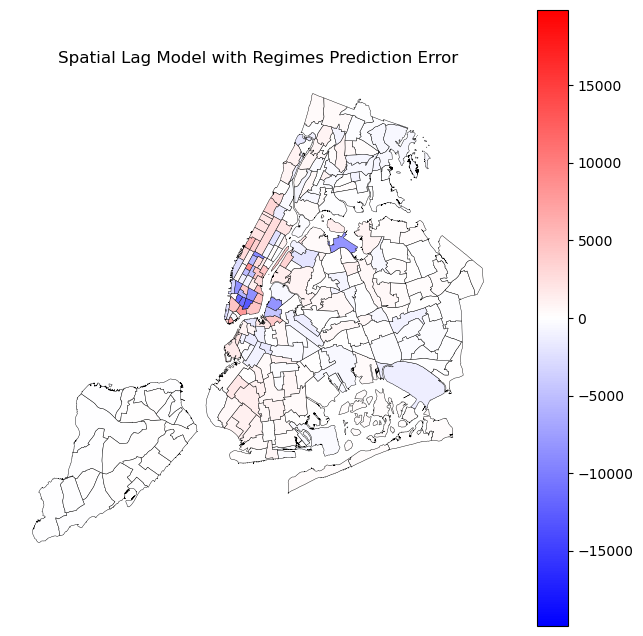

In [69]:
# Create diverging color scheme centered on zero
from matplotlib.colors import TwoSlopeNorm
vmin, vmax, vcenter = (taxi_zones.pickups_per_sq_mile.max()*-1)/2, (taxi_zones.pickups_per_sq_mile.max())/2, 0
norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cmap = 'bwr'
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots(figsize=(8,8))
taxi_zones.plot(ax=ax,column='spatial_lag_regimes_prediction_error', edgecolor='black', linewidth=0.3, cmap=cmap, norm=norm)
fig.colorbar(cbar, ax=ax)
plt.title('Spatial Lag Model with Regimes Prediction Error')
ax.axis('off');

## Combined Spatial Error + Lag with Regimes Model

In [70]:
target_variable = ['pickups_per_sq_mile']
feature_variables = ['night_pop_per_sq_mile', 'day_pop_per_sq_mile']
regimes = taxi_zones['borough']

spatial_error_lag_combo_regimes_model = spreg.GM_Combo_Het_Regimes(
    
    # Target variable
    y = taxi_zones[target_variable].values, 
    
    # Feature variables
    x = taxi_zones[feature_variables].values,
    
    # Specify regimes
    regimes = regimes,
    
    # Target variable name
    name_y = target_variable[0], 
    
    # Feature variable names
    name_x = feature_variables,
    
    # Specify the weights
    w = w
)

In [71]:
taxi_zones['spatial_error_lag_combo_regimes_prediction_error'] = spatial_error_lag_combo_regimes_model.predy[:,0] - taxi_zones['pickups_per_sq_mile']

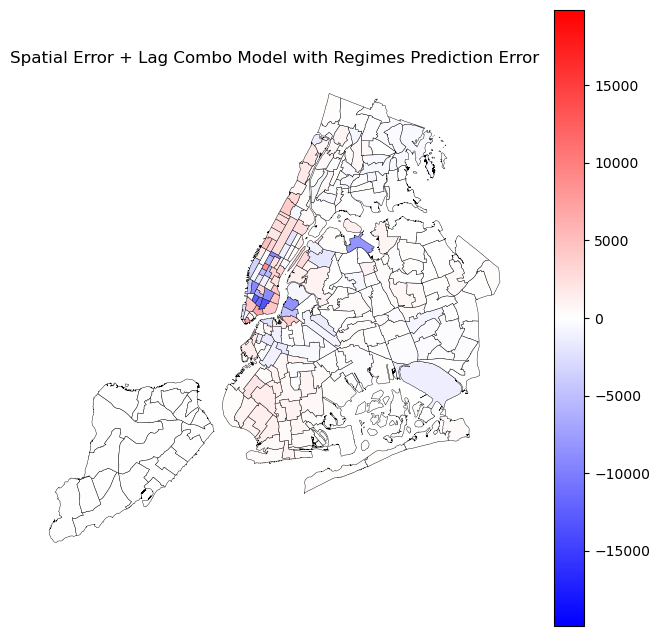

In [72]:
# Create diverging color scheme centered on zero
from matplotlib.colors import TwoSlopeNorm
vmin, vmax, vcenter = (taxi_zones.pickups_per_sq_mile.max()*-1)/2, (taxi_zones.pickups_per_sq_mile.max())/2, 0
norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cmap = 'bwr'
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots(figsize=(8,8))
taxi_zones.plot(ax=ax,column='spatial_error_lag_combo_regimes_prediction_error', edgecolor='black', linewidth=0.3, cmap=cmap, norm=norm)
fig.colorbar(cbar, ax=ax)
plt.title('Spatial Error + Lag Combo Model with Regimes Prediction Error')
ax.axis('off');

## Compare All Models

Compare the distribution of model residuals for all models trained thus far.

In [73]:
taxi_zones.columns

Index(['index', 'location_id', 'geometry', 'shape_area', 'objectid',
       'shape_leng', 'zone', 'borough', 'is_airport', 'pickups',
       'area_sq_mile', 'pickups_per_sq_mile', 'night_pop', 'day_pop',
       'night_pop_per_sq_mile', 'day_pop_per_sq_mile',
       'linear_regression_prediction_error', 'poisson_prediction_error',
       'spatial_error_model_prediction_error',
       'spatial_lag_model_prediction_error',
       'spatial_combo_model_prediction_error', 'regime',
       'linear_regression_regimes_prediction_error',
       'spatial_error_regimes_prediction_error',
       'spatial_lag_regimes_prediction_error',
       'spatial_error_lag_combo_regimes_prediction_error'],
      dtype='object')

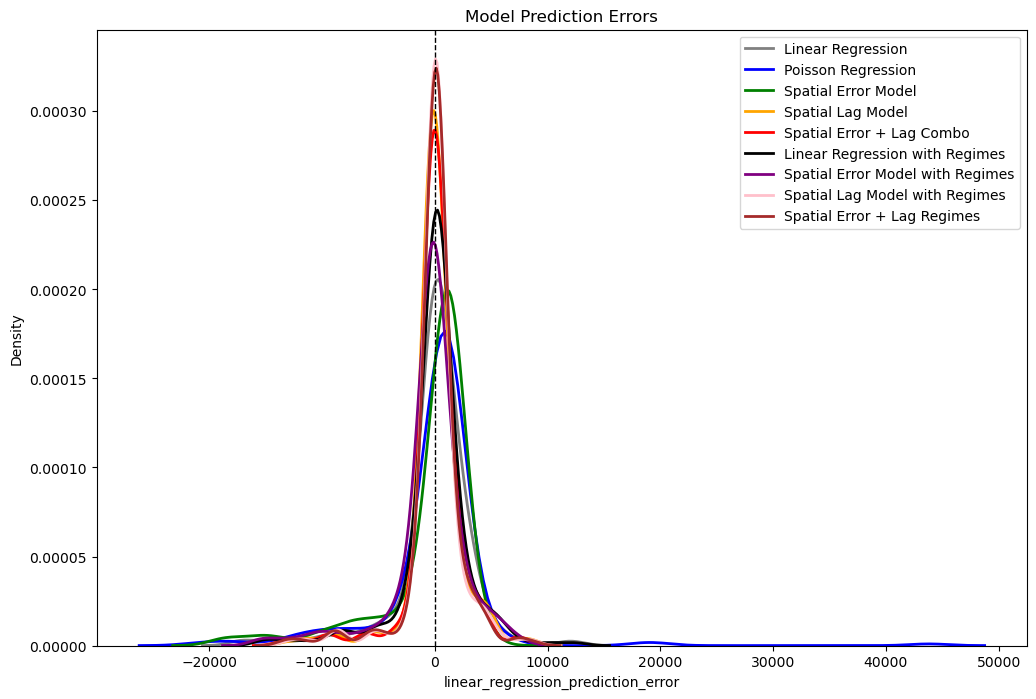

In [74]:
fig, ((ax1)) = plt.subplots(1, 1, figsize=(12,8))
sns.kdeplot(taxi_zones['linear_regression_prediction_error'], ax=ax1, color='gray',linewidth=2, label="Linear Regression")
sns.kdeplot(taxi_zones['poisson_prediction_error'], ax=ax1, color='blue',linewidth=2, label="Poisson Regression")
sns.kdeplot(taxi_zones['spatial_error_model_prediction_error'], ax=ax1, color='green',linewidth=2, label="Spatial Error Model")
sns.kdeplot(taxi_zones['spatial_lag_model_prediction_error'], ax=ax1, color='orange',linewidth=2, label="Spatial Lag Model")
sns.kdeplot(taxi_zones['spatial_combo_model_prediction_error'], ax=ax1, color='red',linewidth=2, label="Spatial Error + Lag Combo")
sns.kdeplot(taxi_zones['linear_regression_regimes_prediction_error'], ax=ax1, color='black',linewidth=2, label="Linear Regression with Regimes")
sns.kdeplot(taxi_zones['spatial_error_regimes_prediction_error'], ax=ax1, color='purple',linewidth=2, label="Spatial Error Model with Regimes")
sns.kdeplot(taxi_zones['spatial_lag_regimes_prediction_error'], ax=ax1, color='pink',linewidth=2, label="Spatial Lag Model with Regimes")
sns.kdeplot(taxi_zones['spatial_error_lag_combo_regimes_prediction_error'], ax=ax1, color='brown',linewidth=2, label="Spatial Error + Lag Regimes")
ax1.axvline(0, color='black', linestyle='--', linewidth=1)
plt.legend(loc='upper right')
plt.title("Model Prediction Errors");

Compare the root mean squared errors for each model.

In [75]:
n = len(taxi_zones)

np.sqrt((taxi_zones[['linear_regression_prediction_error', 'poisson_prediction_error',
       'spatial_error_model_prediction_error',
       'spatial_lag_model_prediction_error',
       'spatial_combo_model_prediction_error',
       'linear_regression_regimes_prediction_error',
       'spatial_error_regimes_prediction_error',
       'spatial_lag_regimes_prediction_error',
       'spatial_error_lag_combo_regimes_prediction_error']]**2).sum()/n).sort_values(ascending=True)

spatial_lag_regimes_prediction_error                2454.968912
spatial_lag_model_prediction_error                  2478.153333
spatial_error_lag_combo_regimes_prediction_error    2492.723239
spatial_combo_model_prediction_error                2519.324540
linear_regression_regimes_prediction_error          3120.556792
spatial_error_regimes_prediction_error              3338.587192
linear_regression_prediction_error                  3418.395888
spatial_error_model_prediction_error                4243.962935
poisson_prediction_error                            5008.293262
dtype: float64

It looks like the spatial lag model with regimes performs the best.

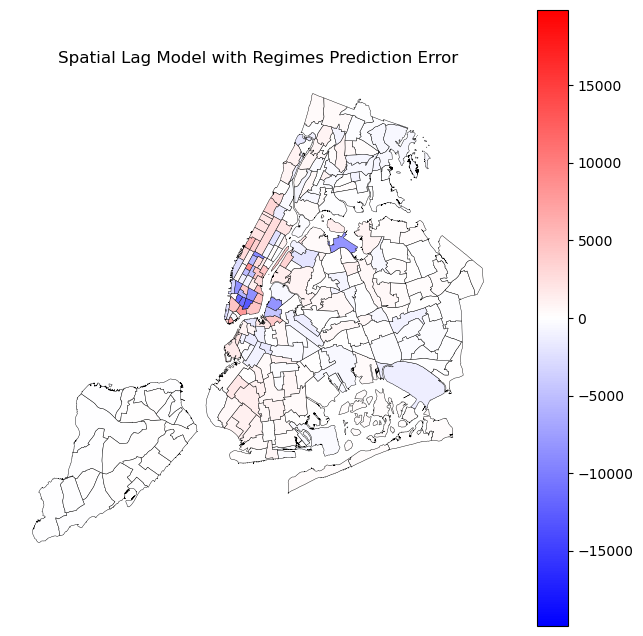

In [76]:
# Create diverging color scheme centered on zero
from matplotlib.colors import TwoSlopeNorm
vmin, vmax, vcenter = (taxi_zones.pickups_per_sq_mile.max()*-1)/2, (taxi_zones.pickups_per_sq_mile.max())/2, 0
norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cmap = 'bwr'
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots(figsize=(8,8))
taxi_zones.plot(ax=ax,column='spatial_lag_regimes_prediction_error', edgecolor='black', linewidth=0.3, cmap=cmap, norm=norm)
fig.colorbar(cbar, ax=ax)
plt.title('Spatial Lag Model with Regimes Prediction Error')
ax.axis('off');

# Geographic Weighted Regression

Demonstrate a GWR model to predict rideshare trips based on daytime and nighttime population, allowing for model parameters with vary with space.

In [77]:
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW

In [78]:
taxi_zones['X'] = taxi_zones['geometry'].centroid.x
taxi_zones['Y'] = taxi_zones['geometry'].centroid.y

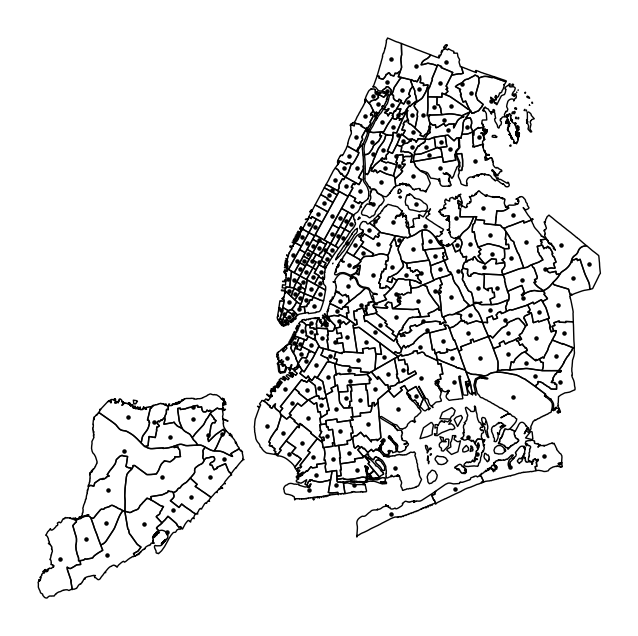

In [79]:
fig, ax = plt.subplots(figsize=(8,8))
taxi_zones.plot(ax=ax,facecolor='none')
taxi_zones.centroid.plot(ax=ax, c='black', markersize=5)
ax.axis('off');

In [80]:
target_variable = ['pickups_per_sq_mile']
feature_variables = ['night_pop_per_sq_mile', 'day_pop_per_sq_mile']

In [81]:
y = taxi_zones[target_variable[0]].values.reshape((-1,1))

In [82]:
X = taxi_zones[feature_variables].values

In [83]:
u = taxi_zones['X']
v = taxi_zones['Y']
coords = list(zip(u,v))

In [84]:
#Calibrate GWR model
gwr_selector = Sel_BW(coords, y, X)
gwr_bw = gwr_selector.search(bw_min=5)
print(gwr_bw)

39.0


In [85]:
gwr_results = GWR(coords, y, X, gwr_bw).fit()

In [86]:
gwr_results.params[0:5]

array([[ 7.60023603e+01, -9.04157608e-03,  7.62433805e-02],
       [ 1.05875366e+01,  3.11789675e-02,  2.36677352e-02],
       [ 3.64756089e+03,  6.84149497e-02,  4.01438194e-02],
       [-9.62423737e+01,  4.39172930e-03,  3.07813259e-02],
       [-6.41940787e+01,  7.78370250e-03,  2.76999598e-02]])

In [87]:
gwr_results.localR2[0:5]

array([[0.775994  ],
       [0.95624862],
       [0.59021075],
       [0.73017725],
       [0.5726538 ]])

In [88]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 258
Number of covariates:                                                     3

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                       3083069207.376
Log-likelihood:                                                   -2468.300
AIC:                                                               4942.600
AICc:                                                              4944.758
BIC:                                                           3083067791.371
R2:                                                                   0.797
Adj. R2:                                                              0.796

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- --

View the GWR results.

In [89]:
taxi_zones['gwr_params_intercept'] = gwr_results.params[:,0]

In [90]:
taxi_zones['gwr_params_night_pop'] = gwr_results.params[:,1]

In [91]:
taxi_zones['gwr_params_day_pop'] = gwr_results.params[:,2]

In [92]:
taxi_zones['gwr_local_rsquared'] = gwr_results.localR2

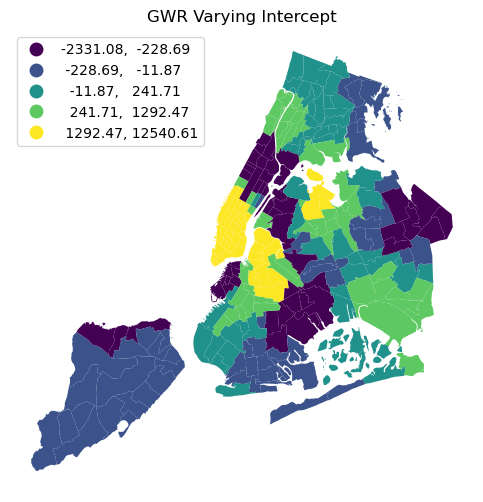

In [93]:
ax = taxi_zones.plot(column='gwr_params_intercept', scheme='quantiles', cmap='viridis', 
                                             legend=True, legend_kwds={'loc': 'upper left'})
plt.title('GWR Varying Intercept')
ax.axis('off');

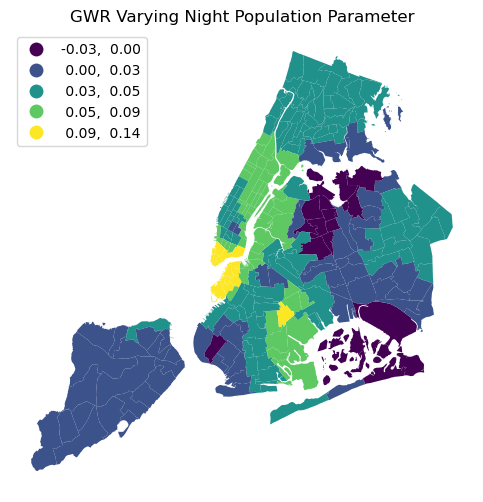

In [94]:
ax = taxi_zones.plot(column='gwr_params_night_pop', scheme='fisher_jenks', cmap='viridis', 
                                             legend=True, legend_kwds={'loc': 'upper left'})
plt.title('GWR Varying Night Population Parameter')
ax.axis('off');

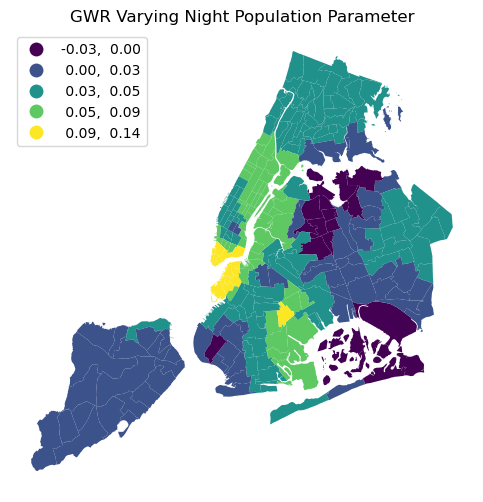

In [95]:
ax = taxi_zones.plot(column='gwr_params_night_pop', scheme='fisher_jenks', cmap='viridis', 
                                             legend=True, legend_kwds={'loc': 'upper left'})
plt.title('GWR Varying Night Population Parameter')
ax.axis('off');

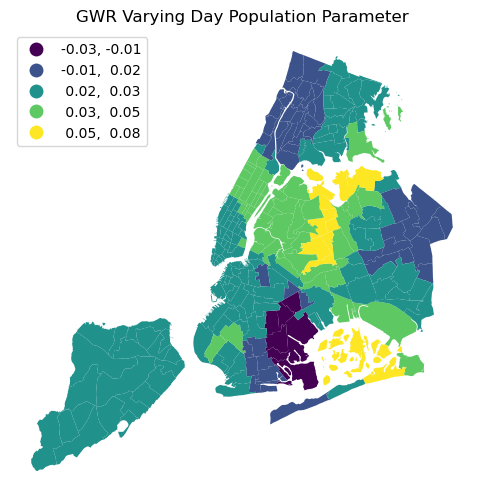

In [96]:
ax = taxi_zones.plot(column='gwr_params_day_pop', scheme='fisher_jenks', cmap='viridis', 
                                             legend=True, legend_kwds={'loc': 'upper left'})
plt.title('GWR Varying Day Population Parameter')
ax.axis('off');

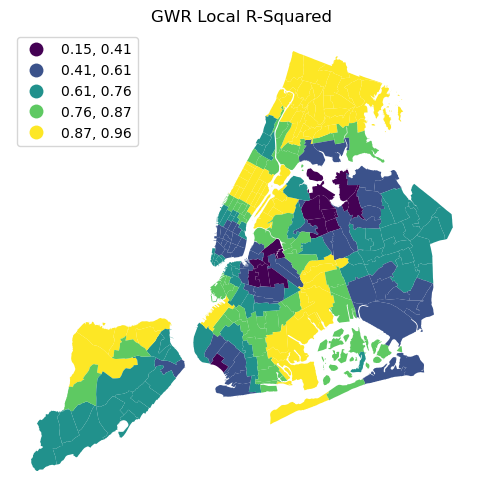

In [97]:
ax = taxi_zones.plot(column='gwr_local_rsquared', scheme='fisher_jenks', cmap='viridis', 
                                             legend=True, legend_kwds={'loc': 'upper left'})
plt.title('GWR Local R-Squared')
ax.axis('off');